# Project 1 - Drug annotation of 23andme report

## Team 14  

- Meagan Burt ()

- Lingrui Cai 

- Kyle Contjes ()

- Catherine Kenney ()



## Part I. Answer to the questions

### Meagan Burt
#### 1.What was your biggest challenge in this project? (regarding writing code and not only) 

I performed task 2 in the project. My biggest challenge was to figure out how to subset on columns ("Phenotype Category") which had a space in the names, which is not necessarily good naming practice and not something that I had done in exercises before. 

#### 2.What did you learn while working on this project? (regarding writing code and not only)

I considered renaming all the columns to replace the space with an underscore or similar to solve the problem that I mentioned in question 1. This is probably what I would have done if coding on my own for a homework assignment. However, since this is a group project, I thought that would make things confusing for group members working on different parts. So after playing with the code for a bit, I learned that could use brackets in order subset on columns that have spaces in the names.

#### 3.If you had more time on the project what other question(s) would you like to answer? (at least one question is required)

I am not a biologist and was missing from even from the background information we were given a lot of the basis that I needed in order to understand what was going on here. I did understand that this project was about drug efficacy based on gene information in humans. Coming at this from the perspective of someone without a strong background in this, and who still doesn't quite know what SNPs are, I think that it would be interesting to take this data and make figures for those who don't have a strong understanding of the concept. Maybe for a user on the 23andme site. 

### Lingrui Cai
#### 1.What was your biggest challenge in this project? (regarding writing code and not only)

I perform task 3&4 in the project. My biggest chanllene was how to fully understand the intention of the task. In task 4, the SNP ID and drug count task seems ambiguous for me at the begining. Even after talk with our group members, we cannot make a decision on how to deal with the list of drug names. Finally it solved after talking with instructor. 

#### 2.What did you learn while working on this project? (regarding writing code and not only)

Regarding to writing code, I realized that the file in reality is not as perfect as we have in the class. For task 4, there are some random quotes added in the drug name string. Printing out the intermediate result is helpful and alway do sanity check step by step. 

Github is a powerful tool for teamwork. In this project, the following task highly depends on the previous one. and it's hard to parallel tasks. We decided to init a github repository and work together with it. It minimized the time spend on meeting since the progress synchronized for everyone.

#### 3.If you had more time on the project what other question(s) would you like to answer? (at least one question is required)

- I would like to group the genes if they associate to the same drug list and see if the gene in one group play the similar function based on drug. For instance, suppose warfarin is a popular treatment for cardiovascular disease. When we group the genes associate with warfarin, are those gene functions asscociate with the disease?

- “Mutation - Pathway - Disease - Drug" asscociation make more sense to me. So if possible I would like to include more information into the analysis and display the result in a comprehensive way. 

### Kyle Gontjes
#### 1.What was your biggest challenge in this project? (regarding writing code and not only)

For this project, I performed task 5. My biggest challenge was the generation of the plot's variables. I had an issue with the generation of the final number of drugs and SPNs associated with genes that had no variants of interest. As highlighted in part 5, the number of genes that did not have a variant of interest was high. After several iterations of miscounting, I found a simple strategy to sum the number of drugs and SNPs associated with a gene using an if-else statement.

#### 2.What did you learn while working on this project? (regarding writing code and not only)

During this project, I improved my ability to manipulate python data structures and simplify my code. For instance, I looped through two variables of interest (DRUG_NAME and dbSNP_IDs) when generating the final number of features associated with the genes. Finally, I gained further familiarity with the plotnine package. As I enjoy using ggplot2 in R, I enjoyed learning how to generate ggplot-like figures in python.

#### 3.If you had more time on the project what other question(s) would you like to answer? (at least one question is required)

a. Is there an association between the variant's functional effect (i.e., phenotype category) and the type of drug (i.e., antibiotic)? For instance, one could inquire whether drugs that have different mechanisms of action are associated with the acquisition of variants that have significantly different functional effects (i.e., dosage or efficacy). 

b. Do variants associated with pediatric populations have significantly different functional effects than variants associated with non-pediatric populations? 

c. What functional pathway (i.e., KEGG) do the genes with significant hits identified in this project belong to? For instance, do genes that have significantly more drugs or SNPs associated with them belong to specific functional pathways?

### Catherine Kenney
1.What was your biggest challenge in this project? (regarding writing code and not only)
I performed task 1 for this project. I had a hard time figuring out how to merge the files. Eventually, I determined that I needed to rename a variable in one of the files so that I could match up the tables. I also struggled to understand why there was a line in the var_ann_drugs file that was bad. After talking with the professor I was able to determine that some of the data was entered incorrectly and then I fixed the data file so we wouldn't get an error anymore.

2.What did you learn while working on this project? (regarding writing code and not only)
I learned how to evaluate data input and determine if it needed to be fixed and then how to fix that input. I also learned how to merge files in python which was something that I have never done before.

3.If you had more time on the project what other question(s) would you like to answer? (at least one question is required)
Which variants appear to have the most significant effect on drug efficacy?
Which drugs have efficacy that seems to be most vulnerable to changes caused by variants?

## Part II Solution

####  Read in files and data preparation

23andme_v5_hg19_ref.txt.gz download from https://github.com/arrogantrobot/23andme2vcf

PharmGKB download from https://www.pharmgkb.org/downloads

Annotation data -> Variant and Clinical Annotations Data -> variantAnnotations.zip

https://api.pharmgkb.org/v1/download/file/data/variantAnnotations.zip

#### 1. Map/merge the 23andme file and the variant-drug annotation file based on dbSNP_ID (also known as rsID).

In [1]:
import pandas as pd
import numpy as np

In [2]:
var_drugs = pd.read_csv('var_drug_ann.tsv', sep = '\t', error_bad_lines = False)
inds = var_drugs.index
var_drugs.index = inds + 1
var_drugs.head()
## added a quote at 4354 to end a string because missing end quote

,Variant Annotation ID,Variant/Haplotypes,Gene,Drug(s),PMID,Phenotype Category,Significance,Notes,Sentence,Alleles,Specialty Population
1,1451159680,rs5031016,CYP2A6,warfarin,22248286,Dosage,no,No association was found between this variant ...,Allele G is not associated with increased dose...,G,NaN
2,1183684657,CYP2D6 ultrarapid metabolizer genotype,CYP2D6,tramadol,18204346,Metabolism/PK,yes,"Median (+)R,R-tramadol area under the curve wa...",CYP2D6 ultra-metabolizer genotype is associate...,NaN,NaN
3,1451306860,CYP2C9*11,CYP2C9,warfarin,33350885,Dosage,not stated,This case suggests that CYP2C9 *11/*11 carrier...,CYP2C9 *11/*11 is associated with decreased do...,*11/*11,NaN
4,1448997750,"CYP2B6*1, CYP2B6*18",CYP2B6,efavirenz,16495778,Metabolism/PK,yes,Please note that in the paper the allele was r...,CYP2B6 *1/*18 is associated with increased con...,*1/*18,NaN
5,1448631821,"CYP2C19*1, CYP2C19*2",CYP2C19,"clomipramine,""desmethyl clomipramine""",28470111,Metabolism/PK,no,in a single individual,CYP2C19 *1/*2 is associated with increased tro...,*1/*2,NaN


In [3]:
ref_file_head = ["CHR", "POS", "dbSNP_ID", "ALLELE"]
ref_file = pd.read_csv('23andme_v5_hg19_ref.txt', sep = '\t')
ref_file.columns = ref_file_head
ref_file.head()

,CHR,POS,dbSNP_ID,ALLELE
0,chr1,74792,rs13328684,G
1,chr1,565508,rs9283150,G
2,chr1,726912,i713426,A
3,chr1,727841,rs116587930,G
4,chr1,752721,rs3131972,A


In [4]:
filtered_vd = var_drugs[(var_drugs['Variant/Haplotypes'].str.startswith('rs')) | (var_drugs['Variant/Haplotypes'].str.startswith('i'))]
filtered_vd = filtered_vd.rename(columns = {"Variant/Haplotypes": "dbSNP_ID"})

var_info = pd.merge(filtered_vd, ref_file)
#var_info is new merged table

#### 2. Filter the output so that it only contains significant associations (SIGNIFICANCE is yes) for variants that affect the drug efficacy (`PHENOTYPE_CATEGORY` is `efficacy`).

In [5]:
var_info = var_info[(var_info.Significance == "yes") & (var_info['Phenotype Category'] == "Efficacy")]
var_info.head()

,Variant Annotation ID,dbSNP_ID,Gene,Drug(s),PMID,Phenotype Category,Significance,Notes,Sentence,Alleles,Specialty Population,CHR,POS,ALLELE
3,1451307920,rs7624046,KCNMB2,ritodrine,32371615,Efficacy,yes,variant-type homozygote carriers of rs7624046 ...,Genotype TT is associated with decreased respo...,TT,NaN,chr3,178461771,C
8,1449716295,rs1128503,ABCB1,fentanyl,22277678,Efficacy,yes,Please note that alleles have been complemente...,Genotype AA is associated with decreased respo...,AA,NaN,chr7,87179601,A
9,1446897429,rs1128503,ABCB1,glucocorticoids,25346426,Efficacy,yes,The GG genotype was more frequent in patients ...,Genotype GG is associated with decreased respo...,GG,NaN,chr7,87179601,A
32,981238152,rs1128503,ABCB1,antipsychotics,22909202,Efficacy,yes,Please note: this variant deviated from Hardy-...,Allele G is associated with increased response...,G,NaN,chr7,87179601,A
35,1449748447,rs1128503,ABCB1,tacrolimus,29615122,Efficacy,yes,Patients with the AA genotype had a higher eff...,Genotype AA is associated with increased respo...,AA,NaN,chr7,87179601,A


#### 3. Save the output of the filtering step in a tab-separated file (23andme_PharmGKB_map.tsv) with the following columns:
dbSNP_ID, GENE_SYMBOL, DRUG_NAME, NOTES, SENTENCE, ALLELE_PharmGKB, ALLELE_23andme

In [6]:
save_cols = ["dbSNP_ID", "Gene", "Drug(s)", "Notes", "Sentence", "Alleles", "ALLELE" ]
new_col_name = ["dbSNP_ID", "GENE_SYMBOL", "DRUG_NAME", "NOTES", "SENTENCE", "ALLELE_PharmGKB", "ALLELE_23andme"]

In [7]:
# replace the column name 
filter_tab = var_info[save_cols]
filter_tab.columns=new_col_name
filter_tab.head()

,dbSNP_ID,GENE_SYMBOL,DRUG_NAME,NOTES,SENTENCE,ALLELE_PharmGKB,ALLELE_23andme
3,rs7624046,KCNMB2,ritodrine,variant-type homozygote carriers of rs7624046 ...,Genotype TT is associated with decreased respo...,TT,C
8,rs1128503,ABCB1,fentanyl,Please note that alleles have been complemente...,Genotype AA is associated with decreased respo...,AA,A
9,rs1128503,ABCB1,glucocorticoids,The GG genotype was more frequent in patients ...,Genotype GG is associated with decreased respo...,GG,A
32,rs1128503,ABCB1,antipsychotics,Please note: this variant deviated from Hardy-...,Allele G is associated with increased response...,G,A
35,rs1128503,ABCB1,tacrolimus,Patients with the AA genotype had a higher eff...,Genotype AA is associated with increased respo...,AA,A


In [8]:
filter_tab.to_csv("23andme_PharmGKB_map.tsv", sep="\t", index=False)

#### 4. Create a tab separated file with summarized data with the following columns:
GENE_SYMBOL, DRUG_NAME, and a list of dbSNP_IDs separated by ";"


In [9]:
sum_dict = {}

for i, row in filter_tab.iterrows():
    gene_sym = row["GENE_SYMBOL"]
    # replace the quote in the some of the drug names
    drug = row["DRUG_NAME"].replace('"', '').split(",")
    snp = row["dbSNP_ID"].split(",")
    
    # check if gene symbol already exist in the dictionary
    if gene_sym in sum_dict.keys():
        sum_dict[gene_sym][0].update(snp)
        sum_dict[gene_sym][1].update(drug)
    else:
        drug_set = set()
        snp_set = set()
        sum_dict[gene_sym] = [snp_set, drug_set ]


In [10]:
gene_list = []
drug_list = []
snp_list = []

for key, value in sum_dict.items():
    #print (key, value)
    gene_list.append(key)
    # process snp
    if len(value[0]) > 0:
        snp_string = [s for s in value[0]]
        snp_list.append(";".join(snp_string))
    else:
        snp_list.append("")

    # process drug
    if len(value[1]) > 0:
        drug_string = [s for s in value[1]]
        drug_list.append(";".join(drug_string))
    else:
        drug_list.append("")

In [11]:
new_df = pd.DataFrame()
new_df["GENE_SYMBOL"] = gene_list
new_df["DRUG_NAME"] = drug_list
new_df["dbSNP_IDs"] = snp_list
new_df.to_csv("summary_table.csv", sep='\t')
new_df.head()

,GENE_SYMBOL,DRUG_NAME,dbSNP_IDs
0,KCNMB2,,
1,ABCB1,clozapine;clopidogrel;imatinib;sevoflurane;ant...,rs1128503;rs7787082;rs1922242;rs10248420
2,HTR2A,olanzapine;fluvoxamine;antidepressants;ustekin...,rs6313;rs6311;rs7997012;rs6314
3,SLCO1B1,capecitabine;fluorouracil;methotrexate;estrone...,rs2900478;rs4149036;rs10841753;rs4149056;rs230...
4,UGT1A1,irinotecan;cisplatin,rs4148323


#### 5. Plot the distribution of the number of drugs associated with a gene, and the number of SNPs for a gene. 

In [12]:
# When creating figures, I prefer to use the ggplot language. In turn, I imported plotnine, a package with similarity to the ggplot package found in R 
    # Import plotnine
from plotnine import *

In [13]:
# Pre-work for Task 5: Calculate the # of Drugs and SNPs associated with a gene

#Create Function to Count Number of Split Strings
def item_count(dataframe): 
    if dataframe[name] == "": # Logical to identifies genes with no significant variant
        return 0 
    else:
        return len(list(set(dataframe[name].split(";")))) # This statement expands the semi-colon separated list within the column and sums the number of unique entries. List(set()) was implemented in case the prior 
    
# Loop Through Variables of Interest
    # Column Name List
columnames = ["DRUG_NAME","dbSNP_IDs"]
    # For Loop Through Each Column Name
for name in columnames:
    new_df[name+"_Sum"] = new_df.apply(item_count, axis=1)

# Print New Dataframe
new_df.head(10)

,GENE_SYMBOL,DRUG_NAME,dbSNP_IDs,DRUG_NAME_Sum,dbSNP_IDs_Sum
0,KCNMB2,,,0,0
1,ABCB1,clozapine;clopidogrel;imatinib;sevoflurane;ant...,rs1128503;rs7787082;rs1922242;rs10248420,15,4
2,HTR2A,olanzapine;fluvoxamine;antidepressants;ustekin...,rs6313;rs6311;rs7997012;rs6314,5,4
3,SLCO1B1,capecitabine;fluorouracil;methotrexate;estrone...,rs2900478;rs4149036;rs10841753;rs4149056;rs230...,15,5
4,UGT1A1,irinotecan;cisplatin,rs4148323,2,1
5,OPRM1,volatile anesthetics;naltrexone;Other general ...,rs1799971;rs10485058,12,2
6,CYP4F2,,,0,0
7,DRD2,clozapine;olanzapine;rasagiline;chlorpromazine...,rs1799978;rs2283265;rs2514218;rs1076560;rs6277...,11,7
8,ANKK1,aripiprazole,rs1800497,1,1
9,"ANKK1,""DRD2""",,,0,0


Summary Statistics for Number of Drugs and Number of SNPs: 

        DRUG_NAME_Sum  dbSNP_IDs_Sum
count     400.000000     400.000000
mean        1.512500       0.935000
std         3.128788       2.355769
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         2.000000       1.000000
max        24.000000      38.000000


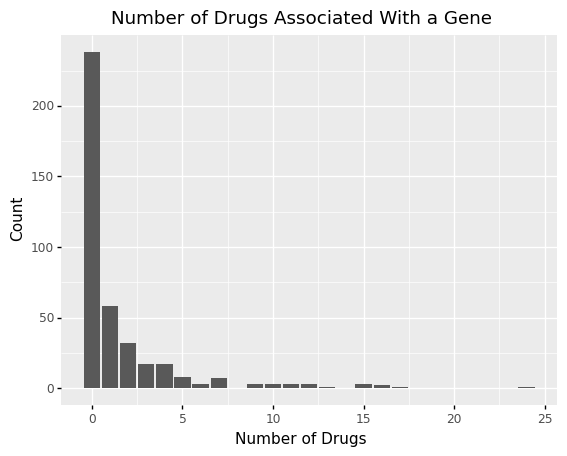

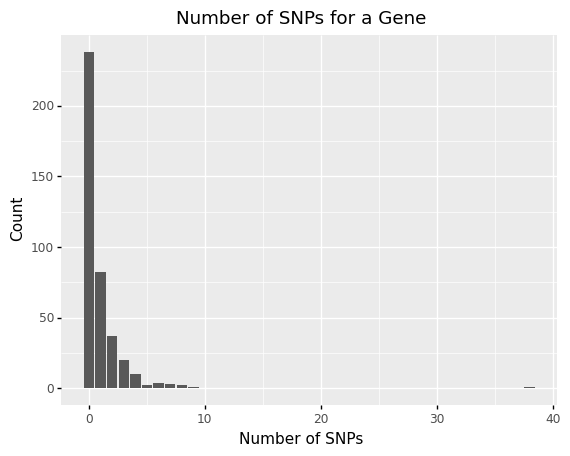

In [14]:
# Note: We kept drugs that had zero significant SNPs in the final figure. As demonstrated below, there were many instances of this occuring

# Summary Statistics
print("Summary Statistics for Number of Drugs and Number of SNPs:",'\n\n',new_df[['DRUG_NAME_Sum','dbSNP_IDs_Sum']].describe())

# Histogram
print(ggplot(data=new_df) + geom_bar(aes("DRUG_NAME_Sum")) + ggtitle("Number of Drugs Associated With a Gene") + xlab("Number of Drugs") + ylab("Count"))
print(ggplot(data=new_df) + geom_bar(aes("dbSNP_IDs_Sum")) + ggtitle("Number of SNPs for a Gene") + xlab("Number of SNPs") + ylab("Count"))

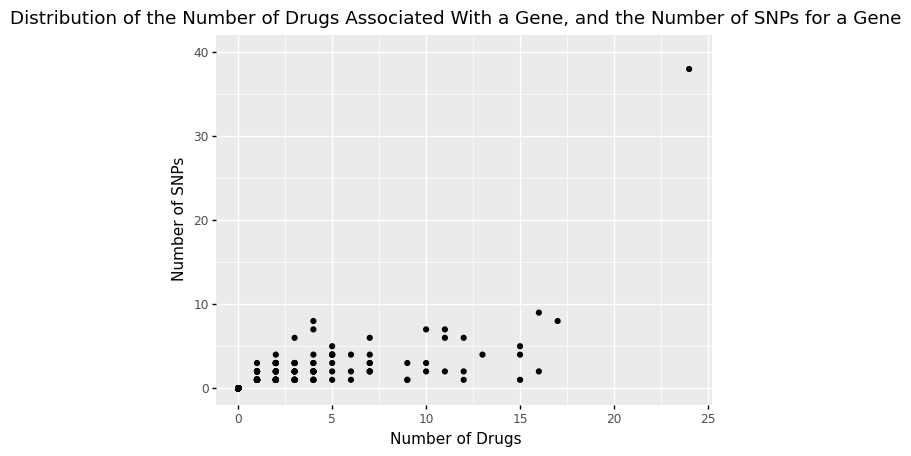

In [15]:
# Output for Task 5
print(ggplot(data=new_df) 
      + geom_point(aes(x="DRUG_NAME_Sum", y = "dbSNP_IDs_Sum")) # Scatter Plot
      + ggtitle("Distribution of the Number of Drugs Associated With a Gene, and the Number of SNPs for a Gene") # Add Title
      + xlab("Number of Drugs") + ylab("Number of SNPs") # Alter X and Y Labels
      + ylim(0,40)) #Increase Limits for Y Axis to Display Tick Mark at 40